In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
#pip install tensorflow-cpu==2.13.0

In [3]:
#pip install numpy==1.24.4 scipy==1.11.4 scikit-learn==1.3.2

In [4]:
def load_and_preprocess(img_path):
    img_raw = tf.io.read_file(img_path)
    img     = tf.image.decode_jpeg(img_raw, channels=3)
    img     = tf.image.resize(img, [224, 224])
    img     = tf.keras.applications.vgg16.preprocess_input(img)
    return tf.expand_dims(img, axis=0)  # shape (1,224,224,3)


In [5]:
# Load VGG16 without top layers, use global average pooling
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)
feature_extractor = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model.output
)


In [6]:
# Helper: load JPEG, resize to 224×224, apply VGG16 preprocessing
def load_and_preprocess(img_path):
    raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = tf.image.resize(img, [224, 224])
    return tf.keras.applications.vgg16.preprocess_input(img)[None, ...]

# Redefine VisionRecommender with parameterized __init__
class VisionRecommender:
    def __init__(self, pca_components=50, n_clusters=8):
        """
        pca_components: number of PCA dimensions to keep
        n_clusters:     number of clusters for KMeans
        """
        # Load VGG16 without top layers
        base = tf.keras.applications.VGG16(
            weights='imagenet', include_top=False, pooling='avg'
        )
        self.extractor = tf.keras.Model(inputs=base.input, outputs=base.output)
        # PCA & KMeans
        self.pca = PCA(n_components=pca_components)
        self.cluster = KMeans(n_clusters=n_clusters, random_state=0)

    def extract_features(self, img_path):
        """
        Load & preprocess via TF, run through CNN,
        return 1D array of length 2048.
        """
        x = load_and_preprocess(img_path)       # (1,224,224,3)
        feats = self.extractor(x)              
        return feats.numpy().flatten()          # 1D numpy array

    def fit(self, image_dir):
        """
        1) Loop all files, skip non-images/folders
        2) Extract features
        3) PCA.fit + KMeans.fit
        """
        feats, paths = [], []
        for fn in os.listdir(image_dir):
            fp = os.path.join(image_dir, fn)
            if not os.path.isfile(fp) or not fn.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            fv = self.extract_features(fp)
            feats.append(fv)
            paths.append(fp)
        X  = np.vstack(feats)                   # (N,2048)
        Xr = self.pca.fit_transform(X)       
        self.cluster.fit(Xr)                  
        self.embeddings = Xr
        self.paths = np.array(paths)

    def recommend(self, query_img, top_k=5):
        """
        Given a query image path:
         1) extract + PCA-transform
         2) find its KMeans label
         3) return top_k closest images in that cluster
        """
        qf    = self.extract_features(query_img).reshape(1, -1)
        qr    = self.pca.transform(qf)
        label = self.cluster.predict(qr)[0]
        mask  = (self.cluster.labels_ == label)
        dists = np.linalg.norm(self.embeddings[mask] - qr, axis=1)
        idxs  = np.argsort(dists)[:top_k]
        return list(self.paths[mask][idxs])

In [7]:
if __name__ == "__main__":
    img_folder = "data/myntradataset/images"
    vr = VisionRecommender(pca_components=50, n_clusters=8)
    vr.fit(img_folder)
#     # List a few files to pick a valid sample
#     files = [f for f in os.listdir(img_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
#     print("Available image files:", files[:5])
#     sample = os.path.join(img_folder, files[0])
#     print("Using sample:", sample)
#     results = vr.recommend(sample, top_k=5)
#     print("Top 5 similar product images:")
#     for path in results:
#         print("  ", path)

C:\Users\junse\miniconda3\envs\dailyfit\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Using sample: data/myntradataset/images\10000.jpg
이게 sample

Query Sample:


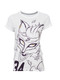


Top 5 Recommendations:


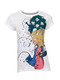

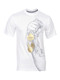

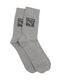

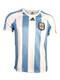

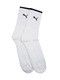

In [8]:
# 1) (Re)compute your recommendations if needed
#    — only if `recs` isn’t already in your namespace
files  = [f for f in os.listdir(img_folder) 
          if f.lower().endswith((".jpg",".jpeg",".png"))]
#sample = os.path.join(img_folder, files[0])
sample = 'data/\\10027.jpg'
raw   = vr.recommend(sample, top_k=6)
# drop the sample itself, take next 5
recs  = [r for r in raw if r != sample][:5]

# 2) Display each image in Jupyter
from IPython.display import display, Image

print("Query Sample:")
display(Image(filename=sample, width=200))

print("\nTop 5 Recommendations:")
for img_path in recs:
    display(Image(filename=img_path, width=200))


In [9]:
sample 

'data/\\10027.jpg'